In [16]:
# Data Management/Investigation
import pandas as pd
import numpy as np

# Data Visualization
from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sns

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

# Machine learning methods 
from sklearn.naive_bayes import GaussianNB as NB
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.tree import DecisionTreeRegressor as DT_reg
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn import tree # For plotting the decision tree rule

# For model interpretation
from sklearn.inspection import (
    permutation_importance,
    partial_dependence, 
    PartialDependenceDisplay, 
    plot_partial_dependence
)

# Misc
import warnings
warnings.filterwarnings("ignore")


In [2]:
# Read
df = pd.read_csv("../07_data_staged/clean_data.csv")
# Drop
df = df.drop(columns=["Week","Season","Team_A","Team_B","Game_pts_diff","Game_yards_diff","Game_TO","Game_yds"])
# Convert
for col in ['Division_Rival','Conference_Rival', 'Grass', 'Home','Same_surface','Win']:
    df[col] = df[col].astype('category')

# Train-test split

In [3]:
# Train test split
y = df['Win']
X = df.drop(columns="Win")
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .25,random_state=42)

# Train model

## Cross validation

In [4]:
# Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=10, shuffle=True,random_state=1234)

### Initialize pipeline

Note that we still want to scale values, but we want to do this in the pipeline since it utilizes information we'll only learn from the training data (i.e. min/max, mean, std, etc.)


In [5]:
pipe = Pipeline(steps=[('pre_process', pp.MinMaxScaler()),('model',None)])

### Select Models & Tuning Parameters


In [6]:
search_space = [
    
    # NaiveBayes
    {'model': [NB()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[5,10,25,50]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DT()],
     'model__max_depth':[2,3,4]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
    'model__max_depth':[2,3,4],
    'model__n_estimators':[500,1000,1500]}   
]

# Alternative method

In [32]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

search_space = [
    {'model': [MLPClassifier()]},    
    {'model' : [KNeighborsClassifier()]},
    {'model': [SVC()]},
    {'model' : [GaussianProcessClassifier()]},
    {'model': [RBF()]},
    {'model' : [DecisionTreeClassifier()]},
    {'model': [GaussianNB()]},
    {'model' : [QuadraticDiscriminantAnalysis()]},
    {'model' : [RandomForestClassifier()]},
    {'model': [AdaBoostClassifier()]},
    {'model' : [GradientBoostingClassifier()]},    
]

### Run models in a GridSearch

In [33]:
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='roc_auc',
                      n_jobs=-1, verbose = 2 )
search.fit(train_X,train_y)

Fitting 10 folds for each of 11 candidates, totalling 110 fits
[CV] END ..............................model=MLPClassifier(); total time=   0.9s
[CV] END .......................model=KNeighborsClassifier(); total time=   0.0s
[CV] END .......................model=KNeighborsClassifier(); total time=   0.0s
[CV] END .......................model=KNeighborsClassifier(); total time=   0.0s
[CV] END .......................model=KNeighborsClassifier(); total time=   0.0s
[CV] END ........................................model=SVC(); total time=   2.1s
[CV] END ..............................model=MLPClassifier(); total time=   1.1s
[CV] END .......................model=KNeighborsClassifier(); total time=   0.0s
[CV] END ........................................model=SVC(); total time=   2.1s
[CV] END ..............................model=MLPClassifier(); total time=   1.0s
[CV] END .......................model=KNeighborsClassifier(); total time=   0.0s
[CV] END .....................................

GridSearchCV(cv=KFold(n_splits=10, random_state=1234, shuffle=True),
             estimator=Pipeline(steps=[('pre_process', MinMaxScaler()),
                                       ('model', None)]),
             n_jobs=-1,
             param_grid=[{'model': [MLPClassifier()]},
                         {'model': [KNeighborsClassifier()]},
                         {'model': [SVC()]},
                         {'model': [GaussianProcessClassifier()]},
                         {'model': [RBF(length_scale=1)]},
                         {'model': [DecisionTreeClassifier()]},
                         {'model': [GaussianNB()]},
                         {'model': [QuadraticDiscriminantAnalysis()]},
                         {'model': [RandomForestClassifier()]},
                         {'model': [AdaBoostClassifier()]},
                         {'model': [GradientBoostingClassifier()]}],
             scoring='roc_auc', verbose=2)

# Performance metrics

In [34]:
# Best score
search.best_score_

0.7236447813495159

In [35]:
# Best parameter
search.best_params_

{'model': GaussianProcessClassifier()}

In [36]:
# Select model
model = search.best_estimator_

### Performance on training data

In [37]:
# ROC AUC score on training data
m.roc_auc_score(train_y,model.predict_proba(train_X)[:,1])

0.7362167735481431

In [38]:
# Accuracy score on training data
m.accuracy_score(train_y,model.predict(train_X))

0.6672403901319564

# Model interpretability

In [39]:
vi = permutation_importance(model,train_X,train_y,n_repeats=5)

In [40]:


# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                           vi = vi['importances_mean'],
                           std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)


vi_dat

,variable,vi,std,low,high
0,Season_SRS,0.026181,0.001998,0.022185,0.030177
1,Home,0.018168,0.001497,0.015173,0.021163
2,Season_offense,0.015299,0.002008,0.011282,0.019316
3,Season_defense,0.011436,0.002691,0.006055,0.016818
4,Season_SoS,0.010882,0.001038,0.008806,0.012957
5,Same_surface,0.002104,0.000415,0.001274,0.002933
6,Attendance_pct,0.002046,0.001323,-0.000600,0.004692
7,Miles_traveled,0.001014,0.000610,-0.000206,0.002233
8,Attendance,0.000918,0.000771,-0.000624,0.002460
9,Division_Rival,0.000822,0.000601,-0.000379,0.002023


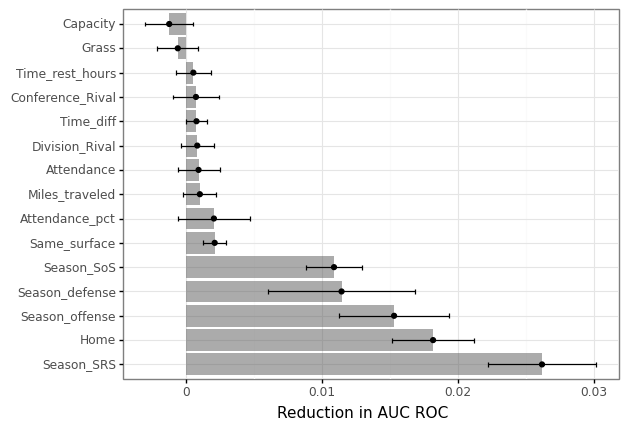

<ggplot: (342918943)>

In [41]:
# Plot
(
    ggplot(vi_dat,
          aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="")
)


# Predict & Out-of-sample performance

In [42]:
y_pred = model.predict(test_X)

In [43]:
# Accuracy score on test set
m.accuracy_score(test_y,y_pred)

0.6448651749856569

In [44]:
# ROC AUC score
m.roc_auc_score(test_y,y_pred)

0.6452252273015361

# ROC Curve

First, we need the model to return **probabilities** not predictions.

In [45]:
probs = model.predict_proba(test_X)
probs =  pd.DataFrame(probs,columns=model.classes_)
probs.head()

,0,1
0,0.608394,0.391606
1,0.227559,0.772441
2,0.462095,0.537905
3,0.193169,0.806831
4,0.777186,0.222814


In [46]:
# Generate the False Positive Rate and True Positive Rate Given different thresholds
fpr, tpr, thresholds = m.roc_curve(test_y, probs[1])

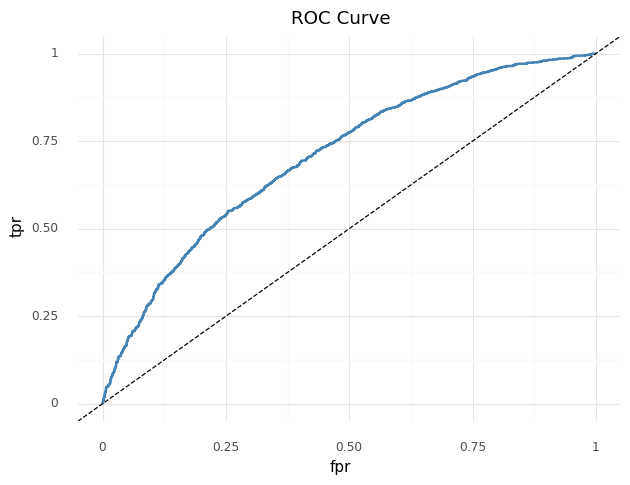

<ggplot: (342917117)>

In [47]:
# Plot the ROC Curve
( 
    ggplot(pd.DataFrame(dict(fpr=fpr,tpr=tpr)),
           aes(x="fpr",y="tpr")) +
    geom_path(color="steelblue",size=1) +
    geom_abline(intercept=0,slope=1,linetype="dashed") +
    theme_minimal() +
    labs(title="ROC Curve") +
    theme(figure_size=(7,5))
)